# March Data Labs - Profiles Group v2 - Final Version
*OOI Data Labs Workshop - March 2019*

Notebook Revised 10/2/2019 by Sage

**Key Goals**
* Students will look at how different parameters are related to photosynthesis, including an “ideal profile” with an Oxygen minimum zone
* Also want students to look at seasonal changes, for eample how do DO and Chl co-vary seasonally? 

**Data Needs**
* Extract monthly 1-2 day samples from 1 year at the Axial profiler (RS03)
* Allow students to plot 2 variables at a time for a given month
* Needed variables: Temp, Salinity, DO, Chlorophyll, pCO2.  Maybe also Nitrate and PAR.
* Potentially show variablilty of multiple profiles (i.e. raw data from 1-2 days) as well as a "clean" profile (averaged) to show the general structure.

**Can we also show deep structure?**
* Unfortunatley, we don't have full profiles in deep locations.  We would need to stich together the one 6-month GI Glider and dataset with the Profiler.
* We could leave a gap at surface to have student guess why data is missing.
* Probably need to exclude data below 1,200m to avoid shwoing confusing features

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
! pip install netcdf4==1.5.0

# Setup default plot styles
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import dask

## Request Data

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL upon success, else return error message
  if 'allURLs' in data.keys():
    return data['allURLs'][0]
  else:
    print('Request Error')
    print(data['message']['status'])
    return data


In [0]:
# Data Requests
sd = '2017-07-31T00:00:00.000Z'
ed = '2018-07-03T00:00:00.000Z'
# request_data('RS03AXPS-SF03A-2A-CTDPFA302','streamed','ctdpf_sbe43_sample',sd,ed)
# request_data('RS03AXPS-SF03A-3A-FLORTD301','streamed','flort_d_data_record',sd,ed)
# request_data('RS03AXPS-SF03A-4F-PCO2WA301','streamed','pco2w_a_sami_data_record',sd,ed)

## Load Data
Axial Base Shallow Profiler Mooring (RS03AXPS)

In [0]:
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190926T155250875Z-RS03AXPS-SF03A-2A-CTDPFA302-streamed-ctdpf_sbe43_sample/catalog.html'
url_flo = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190926T155354183Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/catalog.html'
url_co2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190926T155405097Z-RS03AXPS-SF03A-4F-PCO2WA301-streamed-pco2w_a_sami_data_record/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    elif '_cal_' in d: #Remove pco2 cal streams
      pass
    else:
      selected_datasets.append(d)
  selected_datasets.reverse() # Flip order so older datasets are first
  # print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets) #,data_vars=['seawater_temperature','practical_salinity','corrected_dissolved_oxygen'])
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 3600}) # Used for optimization
  # ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds
  

In [7]:
%%time
ctd_data = get_data(url_ctd)

CPU times: user 6.66 s, sys: 1.25 s, total: 7.91 s
Wall time: 34.1 s


In [8]:
%%time
flo_data = get_data(url_flo,'ctdpf')

CPU times: user 5.7 s, sys: 926 ms, total: 6.63 s
Wall time: 28.9 s


In [9]:
%%time
co2_data = get_data(url_co2,'ctdpf')

CPU times: user 77.6 ms, sys: 10.5 ms, total: 88 ms
Wall time: 1.96 s


## Remove Outliers
First, we need to remove some outliers in the raw dataset

In [0]:
import numpy as np
def reject_outliers(data, m=3):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
# Remove outliers
# ctd_data = ctd_data.where(ctd_data.int_ctd_pressure<250)
# ctd_data = ctd_data.where(ctd_data.practical_salinity>0)
# ctd_data['practical_salinity'] = ctd_data['practical_salinity'].where(reject_outliers(ctd_data['practical_salinity']))
# ctd_data['corrected_dissolved_oxygen'] = ctd_data['corrected_dissolved_oxygen'].where(reject_outliers(ctd_data['corrected_dissolved_oxygen']))

# flo_data = flo_data.where(flo_data.int_ctd_pressure<250)
# flo_data['sci_flbbcd_chlor_units'] = flo_data['sci_flbbcd_chlor_units'].where(flo_data['sci_flbbcd_chlor_units']<5)
# flo_data['fluorometric_chlorophyll_a'] = flo_data['fluorometric_chlorophyll_a'].where(reject_outliers(flo_data['fluorometric_chlorophyll_a']))


## Subset and Bin Data

In [0]:
# Tweak the depth variables for binning
ctd_data['int_ctd_pressure'] = ctd_data['seawater_pressure']
flo_data = flo_data.reset_coords('int_ctd_pressure')
co2_data = co2_data.reset_coords('int_ctd_pressure')

In [0]:
# Day and Depth Binning Function
def bindata(vd,binvar):
  bins = np.arange(0, 200, 2) #Specify depth bins here
  labels = (bins[:-1] + bins[1:])/2
  a = vd.groupby_bins(binvar,bins,labels=labels).mean(dim=xr.ALL_DIMS, skipna=True)
  return a

In [13]:
# Specify dates to process
dates = pd.date_range('2017-08-01', periods=24, freq='SMS')
dates

DatetimeIndex(['2017-08-01', '2017-08-15', '2017-09-01', '2017-09-15',
               '2017-10-01', '2017-10-15', '2017-11-01', '2017-11-15',
               '2017-12-01', '2017-12-15', '2018-01-01', '2018-01-15',
               '2018-02-01', '2018-02-15', '2018-03-01', '2018-03-15',
               '2018-04-01', '2018-04-15', '2018-05-01', '2018-05-15',
               '2018-06-01', '2018-06-15', '2018-07-01', '2018-07-15'],
              dtype='datetime64[ns]', freq='SMS-15')

In [0]:
# Specify the variables we want
var_list_ctd = ['int_ctd_pressure','seawater_temperature','practical_salinity','corrected_dissolved_oxygen']
var_list_flo = ['int_ctd_pressure','fluorometric_chlorophyll_a']
var_list_co2 = ['int_ctd_pressure','pco2_seawater']

In [15]:
# And now we do the depth binning for the selected dates
dsout = False
for d in dates:
  print(d)
  ds1 = ctd_data[var_list_ctd].sel(time=slice(d,d+pd.Timedelta('1 day'))).load()
  ds2 = flo_data[var_list_flo].sel(time=slice(d,d+pd.Timedelta('1 day'))).load()
  ds3 = co2_data[var_list_co2].sel(time=slice(d,d+pd.Timedelta('1 day'))).load()
  ds = ds1.combine_first(ds2).combine_first(ds3)
  if ds.sizes['time'] > 0:
    dsr = ds.resample(time='1D').apply(bindata,binvar='int_ctd_pressure')
    if(isinstance(dsout,xr.Dataset)):
      dsout = xr.concat([dsout, dsr],dim='time')
    else:
      dsout = dsr

2017-08-01 00:00:00
2017-08-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-09-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-09-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-10-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-10-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-11-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-11-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-12-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2017-12-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-01-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-01-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-02-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-02-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-03-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-03-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-04-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-04-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-05-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-05-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-06-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-06-15 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-07-01 00:00:00


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2018-07-15 00:00:00


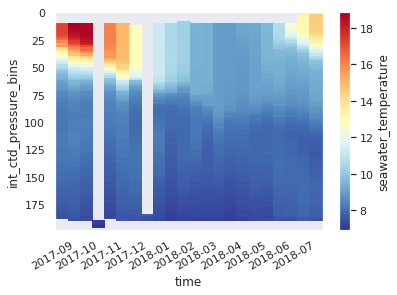

In [16]:
# dsout.seawater_temperature.plot(x='time',y='int_ctd_pressure_bins',cmap='RdYlBu_r',vmin=2,vmax=9,yincrease=False);
dsout.seawater_temperature.plot(x='time',y='int_ctd_pressure_bins',cmap='RdYlBu_r',yincrease=False);

In [0]:
pldata = dsout.to_dataframe().reset_index()
pldata = pldata.dropna(subset=['int_ctd_pressure'])

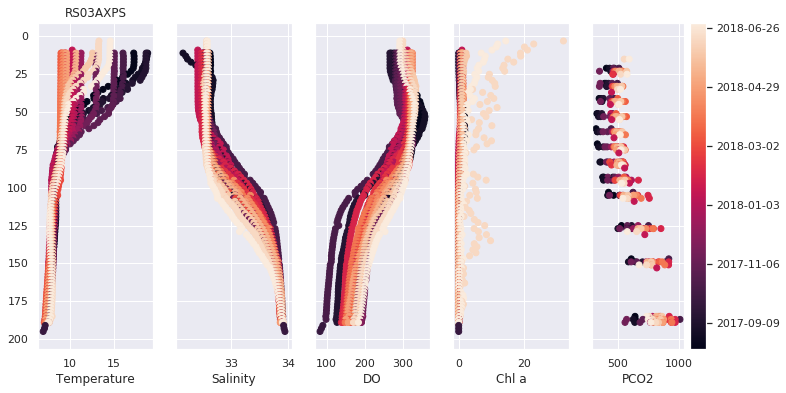

In [18]:
# Plot the profiles
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(12,6))
sc1 = ax1.scatter(pldata.seawater_temperature, pldata.int_ctd_pressure_bins, c=pldata.time);
ax1.set_title('RS03AXPS')
ax1.set_xlabel('Temperature')
ax1.invert_yaxis();
ax2.scatter(pldata.practical_salinity, pldata.int_ctd_pressure_bins, c=pldata.time);
ax2.set_xlabel('Salinity')
ax3.scatter(pldata.corrected_dissolved_oxygen, pldata.int_ctd_pressure_bins, c=pldata.time);
ax3.set_xlabel('DO')
ax4.scatter(pldata.fluorometric_chlorophyll_a, pldata.int_ctd_pressure_bins, c=pldata.time);
ax4.set_xlabel('Chl a')
ax5.scatter(pldata.pco2_seawater, pldata.int_ctd_pressure_bins, c=pldata.time);
ax5.set_xlabel('PCO2')

cbar = fig.colorbar(sc1, ax=ax5, orientation='vertical')
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));



In [19]:
pldata.describe()

,int_ctd_pressure_bins,int_ctd_pressure,seawater_temperature,practical_salinity,corrected_dissolved_oxygen,fluorometric_chlorophyll_a,pco2_seawater
count,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,328.000000
mean,99.783664,99.788639,9.027549,33.143088,247.859860,0.828592,570.765759
std,52.350764,52.330787,2.086273,0.541625,65.105037,2.040902,154.233073
min,3.000000,3.891079,6.930300,32.173066,82.210688,0.040256,319.832215
25%,55.000000,54.985742,7.847101,32.604574,187.101576,0.060020,467.018947
50%,99.000000,99.015517,8.251095,33.044576,258.780586,0.242230,527.198985
75%,145.000000,145.001049,9.302940,33.748077,311.148679,0.957333,658.471161
max,195.000000,194.148850,18.860392,33.941909,358.565183,32.046000,1012.130195


In [0]:
pldata.to_csv('rs03axps_profiles.csv')